In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn

5.973262521249683

## Initialize model at full charge to 4.1V

In [3]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
    "SEI resistivity [Ohm.m]": 0,
})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [4]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 2.5
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.9045382294223173
0.26790266184827943


## One cycle

In [5]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [6]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.6147752325586207, step=0.03614775232558621…

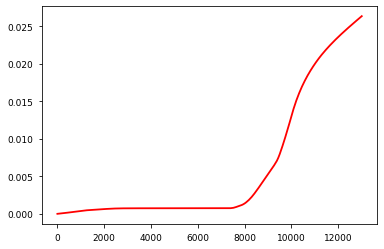

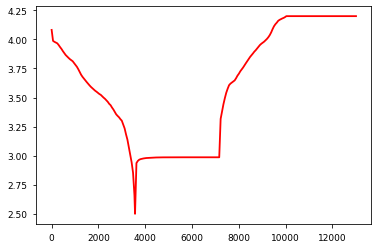

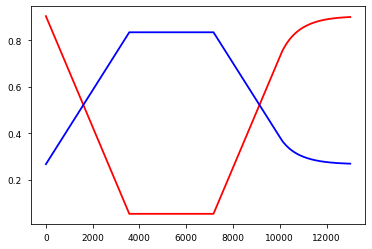

In [7]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [8]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## Several cycles

In [12]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 173,
termination="80% capacity"
)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
spm_sol_100 = sim_100.solve()

2021-03-21 18:42:58,189 - [NOTICE] simulation.solve(701): Cycle 1/173 (26.213 ms elapsed) --------------------
2021-03-21 18:42:58,190 - [NOTICE] simulation.solve(731): Cycle 1/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:42:58,366 - [NOTICE] simulation.solve(731): Cycle 1/173, step 2/4: Rest for 1 hour
2021-03-21 18:42:58,510 - [NOTICE] simulation.solve(731): Cycle 1/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:42:58,660 - [NOTICE] simulation.solve(731): Cycle 1/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:42:59,084 - [NOTICE] simulation.solve(807): Capacity is now 5.093 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:42:59,085 - [NOTICE] simulation.solve(701): Cycle 2/173 (921.720 ms elapsed) --------------------
2021-03-21 18:42:59,085 - [NOTICE] simulation.solve(731): Cycle 2/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:42:59,223 - [NOTICE] simulation.solve(731): Cycle 2/173, step 2/4: Rest for 1 hour
2021-03-21 18:42:59,335 - [NO

2021-03-21 18:43:05,334 - [NOTICE] simulation.solve(731): Cycle 13/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:05,519 - [NOTICE] simulation.solve(807): Capacity is now 5.074 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:05,520 - [NOTICE] simulation.solve(701): Cycle 14/173 (7.357 s elapsed) --------------------
2021-03-21 18:43:05,521 - [NOTICE] simulation.solve(731): Cycle 14/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:05,643 - [NOTICE] simulation.solve(731): Cycle 14/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:05,748 - [NOTICE] simulation.solve(731): Cycle 14/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:05,847 - [NOTICE] simulation.solve(731): Cycle 14/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:06,040 - [NOTICE] simulation.solve(807): Capacity is now 5.072 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:06,041 - [NOTICE] simulation.solve(701): Cycle 15/173 (7.878 s elapsed) --------------------

2021-03-21 18:43:11,896 - [NOTICE] simulation.solve(731): Cycle 26/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:12,015 - [NOTICE] simulation.solve(731): Cycle 26/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:12,121 - [NOTICE] simulation.solve(731): Cycle 26/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:12,214 - [NOTICE] simulation.solve(731): Cycle 26/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:12,392 - [NOTICE] simulation.solve(807): Capacity is now 5.052 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:12,393 - [NOTICE] simulation.solve(701): Cycle 27/173 (14.229 s elapsed) --------------------
2021-03-21 18:43:12,393 - [NOTICE] simulation.solve(731): Cycle 27/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:12,512 - [NOTICE] simulation.solve(731): Cycle 27/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:12,612 - [NOTICE] simulation.solve(731): Cycle 27/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:12,714 - [NO

2021-03-21 18:43:18,634 - [NOTICE] simulation.solve(731): Cycle 38/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:18,819 - [NOTICE] simulation.solve(807): Capacity is now 5.030 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:18,820 - [NOTICE] simulation.solve(701): Cycle 39/173 (20.657 s elapsed) --------------------
2021-03-21 18:43:18,821 - [NOTICE] simulation.solve(731): Cycle 39/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:18,935 - [NOTICE] simulation.solve(731): Cycle 39/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:19,047 - [NOTICE] simulation.solve(731): Cycle 39/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:19,142 - [NOTICE] simulation.solve(731): Cycle 39/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:19,324 - [NOTICE] simulation.solve(807): Capacity is now 5.029 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:19,325 - [NOTICE] simulation.solve(701): Cycle 40/173 (21.162 s elapsed) ------------------

2021-03-21 18:43:25,117 - [NOTICE] simulation.solve(731): Cycle 51/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:25,235 - [NOTICE] simulation.solve(731): Cycle 51/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:25,338 - [NOTICE] simulation.solve(731): Cycle 51/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:25,436 - [NOTICE] simulation.solve(731): Cycle 51/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:25,623 - [NOTICE] simulation.solve(807): Capacity is now 5.007 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:25,624 - [NOTICE] simulation.solve(701): Cycle 52/173 (27.460 s elapsed) --------------------
2021-03-21 18:43:25,624 - [NOTICE] simulation.solve(731): Cycle 52/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:25,753 - [NOTICE] simulation.solve(731): Cycle 52/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:25,878 - [NOTICE] simulation.solve(731): Cycle 52/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:25,995 - [NO

2021-03-21 18:43:32,182 - [NOTICE] simulation.solve(731): Cycle 63/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:32,368 - [NOTICE] simulation.solve(807): Capacity is now 4.986 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:32,369 - [NOTICE] simulation.solve(701): Cycle 64/173 (34.206 s elapsed) --------------------
2021-03-21 18:43:32,370 - [NOTICE] simulation.solve(731): Cycle 64/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:32,507 - [NOTICE] simulation.solve(731): Cycle 64/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:32,627 - [NOTICE] simulation.solve(731): Cycle 64/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:32,733 - [NOTICE] simulation.solve(731): Cycle 64/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:32,933 - [NOTICE] simulation.solve(807): Capacity is now 4.985 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:32,933 - [NOTICE] simulation.solve(701): Cycle 65/173 (34.770 s elapsed) ------------------

2021-03-21 18:43:38,844 - [NOTICE] simulation.solve(731): Cycle 76/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:38,958 - [NOTICE] simulation.solve(731): Cycle 76/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:39,080 - [NOTICE] simulation.solve(731): Cycle 76/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:39,173 - [NOTICE] simulation.solve(731): Cycle 76/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:39,382 - [NOTICE] simulation.solve(807): Capacity is now 4.963 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:39,383 - [NOTICE] simulation.solve(701): Cycle 77/173 (41.219 s elapsed) --------------------
2021-03-21 18:43:39,384 - [NOTICE] simulation.solve(731): Cycle 77/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:39,500 - [NOTICE] simulation.solve(731): Cycle 77/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:39,620 - [NOTICE] simulation.solve(731): Cycle 77/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:39,720 - [NO

2021-03-21 18:43:45,901 - [NOTICE] simulation.solve(731): Cycle 88/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:46,107 - [NOTICE] simulation.solve(807): Capacity is now 4.943 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:46,108 - [NOTICE] simulation.solve(701): Cycle 89/173 (47.944 s elapsed) --------------------
2021-03-21 18:43:46,109 - [NOTICE] simulation.solve(731): Cycle 89/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:46,226 - [NOTICE] simulation.solve(731): Cycle 89/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:46,336 - [NOTICE] simulation.solve(731): Cycle 89/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:46,437 - [NOTICE] simulation.solve(731): Cycle 89/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:46,646 - [NOTICE] simulation.solve(807): Capacity is now 4.941 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:46,646 - [NOTICE] simulation.solve(701): Cycle 90/173 (48.482 s elapsed) ------------------

2021-03-21 18:43:52,583 - [NOTICE] simulation.solve(731): Cycle 101/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:52,701 - [NOTICE] simulation.solve(731): Cycle 101/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:52,819 - [NOTICE] simulation.solve(731): Cycle 101/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:52,929 - [NOTICE] simulation.solve(731): Cycle 101/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:53,159 - [NOTICE] simulation.solve(807): Capacity is now 4.922 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:53,160 - [NOTICE] simulation.solve(701): Cycle 102/173 (54.996 s elapsed) --------------------
2021-03-21 18:43:53,161 - [NOTICE] simulation.solve(731): Cycle 102/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:53,280 - [NOTICE] simulation.solve(731): Cycle 102/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:53,398 - [NOTICE] simulation.solve(731): Cycle 102/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:43:53,5

2021-03-21 18:43:59,514 - [NOTICE] simulation.solve(731): Cycle 113/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:43:59,708 - [NOTICE] simulation.solve(807): Capacity is now 4.900 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:43:59,710 - [NOTICE] simulation.solve(701): Cycle 114/173 (1 minute, 2 seconds elapsed) --------------------
2021-03-21 18:43:59,711 - [NOTICE] simulation.solve(731): Cycle 114/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:43:59,833 - [NOTICE] simulation.solve(731): Cycle 114/173, step 2/4: Rest for 1 hour
2021-03-21 18:43:59,968 - [NOTICE] simulation.solve(731): Cycle 114/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:00,085 - [NOTICE] simulation.solve(731): Cycle 114/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:44:00,284 - [NOTICE] simulation.solve(807): Capacity is now 4.899 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:00,285 - [NOTICE] simulation.solve(701): Cycle 115/173 (1 minute, 2 second

2021-03-21 18:44:06,291 - [NOTICE] simulation.solve(807): Capacity is now 4.880 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:06,292 - [NOTICE] simulation.solve(701): Cycle 126/173 (1 minute, 8 seconds elapsed) --------------------
2021-03-21 18:44:06,293 - [NOTICE] simulation.solve(731): Cycle 126/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:06,434 - [NOTICE] simulation.solve(731): Cycle 126/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:06,554 - [NOTICE] simulation.solve(731): Cycle 126/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:06,659 - [NOTICE] simulation.solve(731): Cycle 126/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:44:06,853 - [NOTICE] simulation.solve(807): Capacity is now 4.879 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:06,854 - [NOTICE] simulation.solve(701): Cycle 127/173 (1 minute, 9 seconds elapsed) --------------------
2021-03-21 18:44:06,854 - [NOTICE] simulation.solve(731): Cycle 127/173, st

2021-03-21 18:44:13,269 - [NOTICE] simulation.solve(701): Cycle 138/173 (1 minute, 15 seconds elapsed) --------------------
2021-03-21 18:44:13,269 - [NOTICE] simulation.solve(731): Cycle 138/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:13,389 - [NOTICE] simulation.solve(731): Cycle 138/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:13,508 - [NOTICE] simulation.solve(731): Cycle 138/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:13,612 - [NOTICE] simulation.solve(731): Cycle 138/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:44:13,828 - [NOTICE] simulation.solve(807): Capacity is now 4.859 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:13,829 - [NOTICE] simulation.solve(701): Cycle 139/173 (1 minute, 16 seconds elapsed) --------------------
2021-03-21 18:44:13,829 - [NOTICE] simulation.solve(731): Cycle 139/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:13,956 - [NOTICE] simulation.solve(731): Cycle 139/173, step 2/4: Rest for

2021-03-21 18:44:19,948 - [NOTICE] simulation.solve(731): Cycle 150/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:20,080 - [NOTICE] simulation.solve(731): Cycle 150/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:20,192 - [NOTICE] simulation.solve(731): Cycle 150/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:20,298 - [NOTICE] simulation.solve(731): Cycle 150/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:44:20,497 - [NOTICE] simulation.solve(807): Capacity is now 4.840 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:20,497 - [NOTICE] simulation.solve(701): Cycle 151/173 (1 minute, 22 seconds elapsed) --------------------
2021-03-21 18:44:20,498 - [NOTICE] simulation.solve(731): Cycle 151/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:20,622 - [NOTICE] simulation.solve(731): Cycle 151/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:20,736 - [NOTICE] simulation.solve(731): Cycle 151/173, step 3/4: Charge at 1C until 4.2V
2021-03-2

2021-03-21 18:44:26,736 - [NOTICE] simulation.solve(731): Cycle 162/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:26,853 - [NOTICE] simulation.solve(731): Cycle 162/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:26,959 - [NOTICE] simulation.solve(731): Cycle 162/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 18:44:27,168 - [NOTICE] simulation.solve(807): Capacity is now 4.821 Ah (originally 5.093 Ah, will stop at 4.074 Ah)
2021-03-21 18:44:27,169 - [NOTICE] simulation.solve(701): Cycle 163/173 (1 minute, 29 seconds elapsed) --------------------
2021-03-21 18:44:27,169 - [NOTICE] simulation.solve(731): Cycle 163/173, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:27,284 - [NOTICE] simulation.solve(731): Cycle 163/173, step 2/4: Rest for 1 hour
2021-03-21 18:44:27,404 - [NOTICE] simulation.solve(731): Cycle 163/173, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:27,511 - [NOTICE] simulation.solve(731): Cycle 163/173, step 4/4: Hold at 4.2V until C/50
2021-03-21 1

In [13]:
spm_sol_100

In [14]:
sim_100.solve(starting_solution=spm_sol_100)

2021-03-21 18:44:59,472 - [NOTICE] simulation.solve(701): Cycle 174/346 (47.185 ms elapsed) --------------------
2021-03-21 18:44:59,473 - [NOTICE] simulation.solve(731): Cycle 174/346, step 1/4: Discharge at 1C until 2.5V
2021-03-21 18:44:59,608 - [NOTICE] simulation.solve(731): Cycle 174/346, step 2/4: Rest for 1 hour
2021-03-21 18:44:59,731 - [NOTICE] simulation.solve(731): Cycle 174/346, step 3/4: Charge at 1C until 4.2V
2021-03-21 18:44:59,847 - [NOTICE] simulation.solve(731): Cycle 174/346, step 4/4: Hold at 4.2V until C/50
CasADi - 2021-03-21 18:45:00 WARNING("roots:g failed: NaN detected for output x, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-03-21 18:45:00 WARNING("roots:jac_f_z failed: NaN detected for output x, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]


SolverError: Could not find acceptable solution: solver returned NaNs

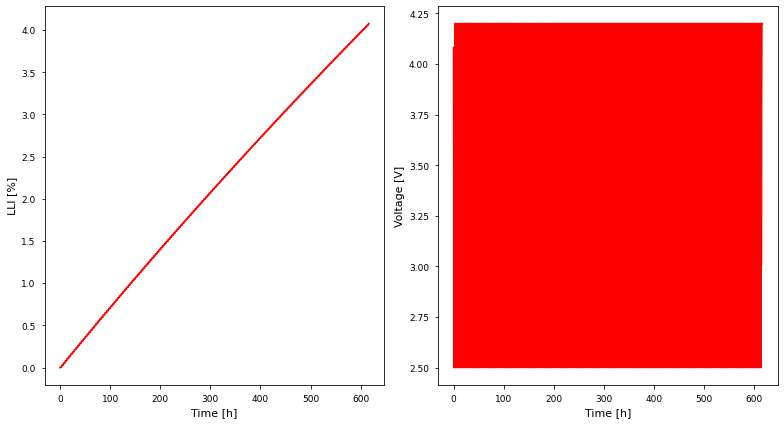

In [15]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

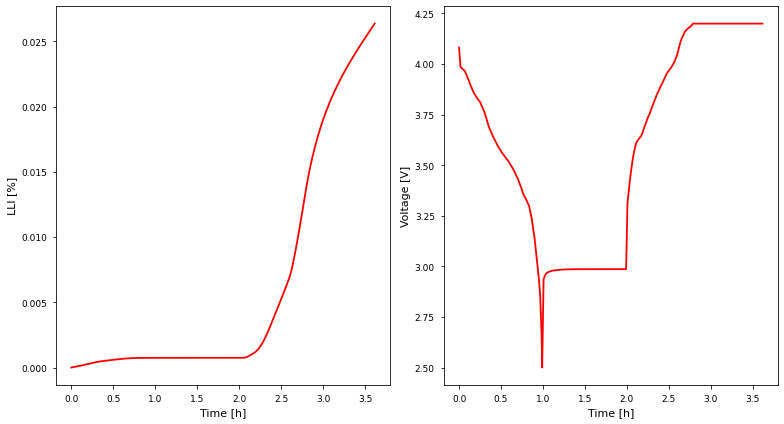

In [16]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [17]:
lli_100 = spm_sol_100["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

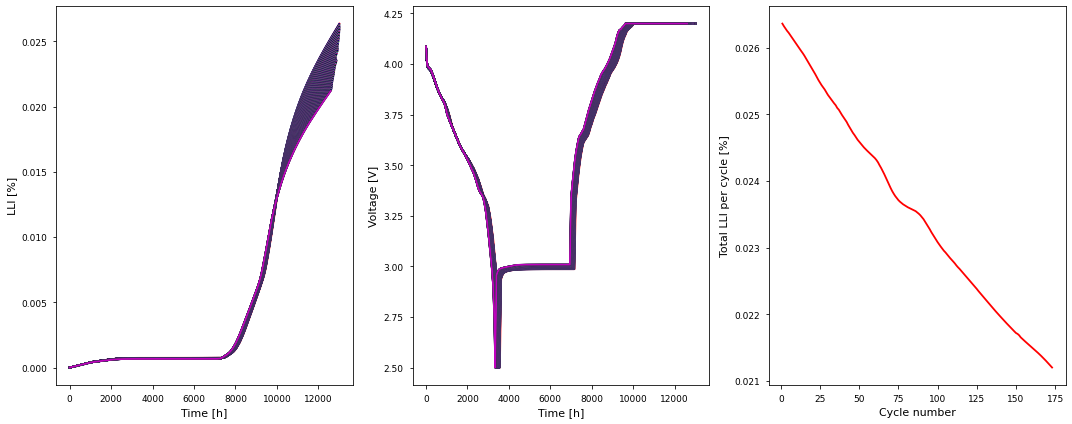

In [18]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_100.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [19]:
len(spm_sol_100.summary_variables.items())

71

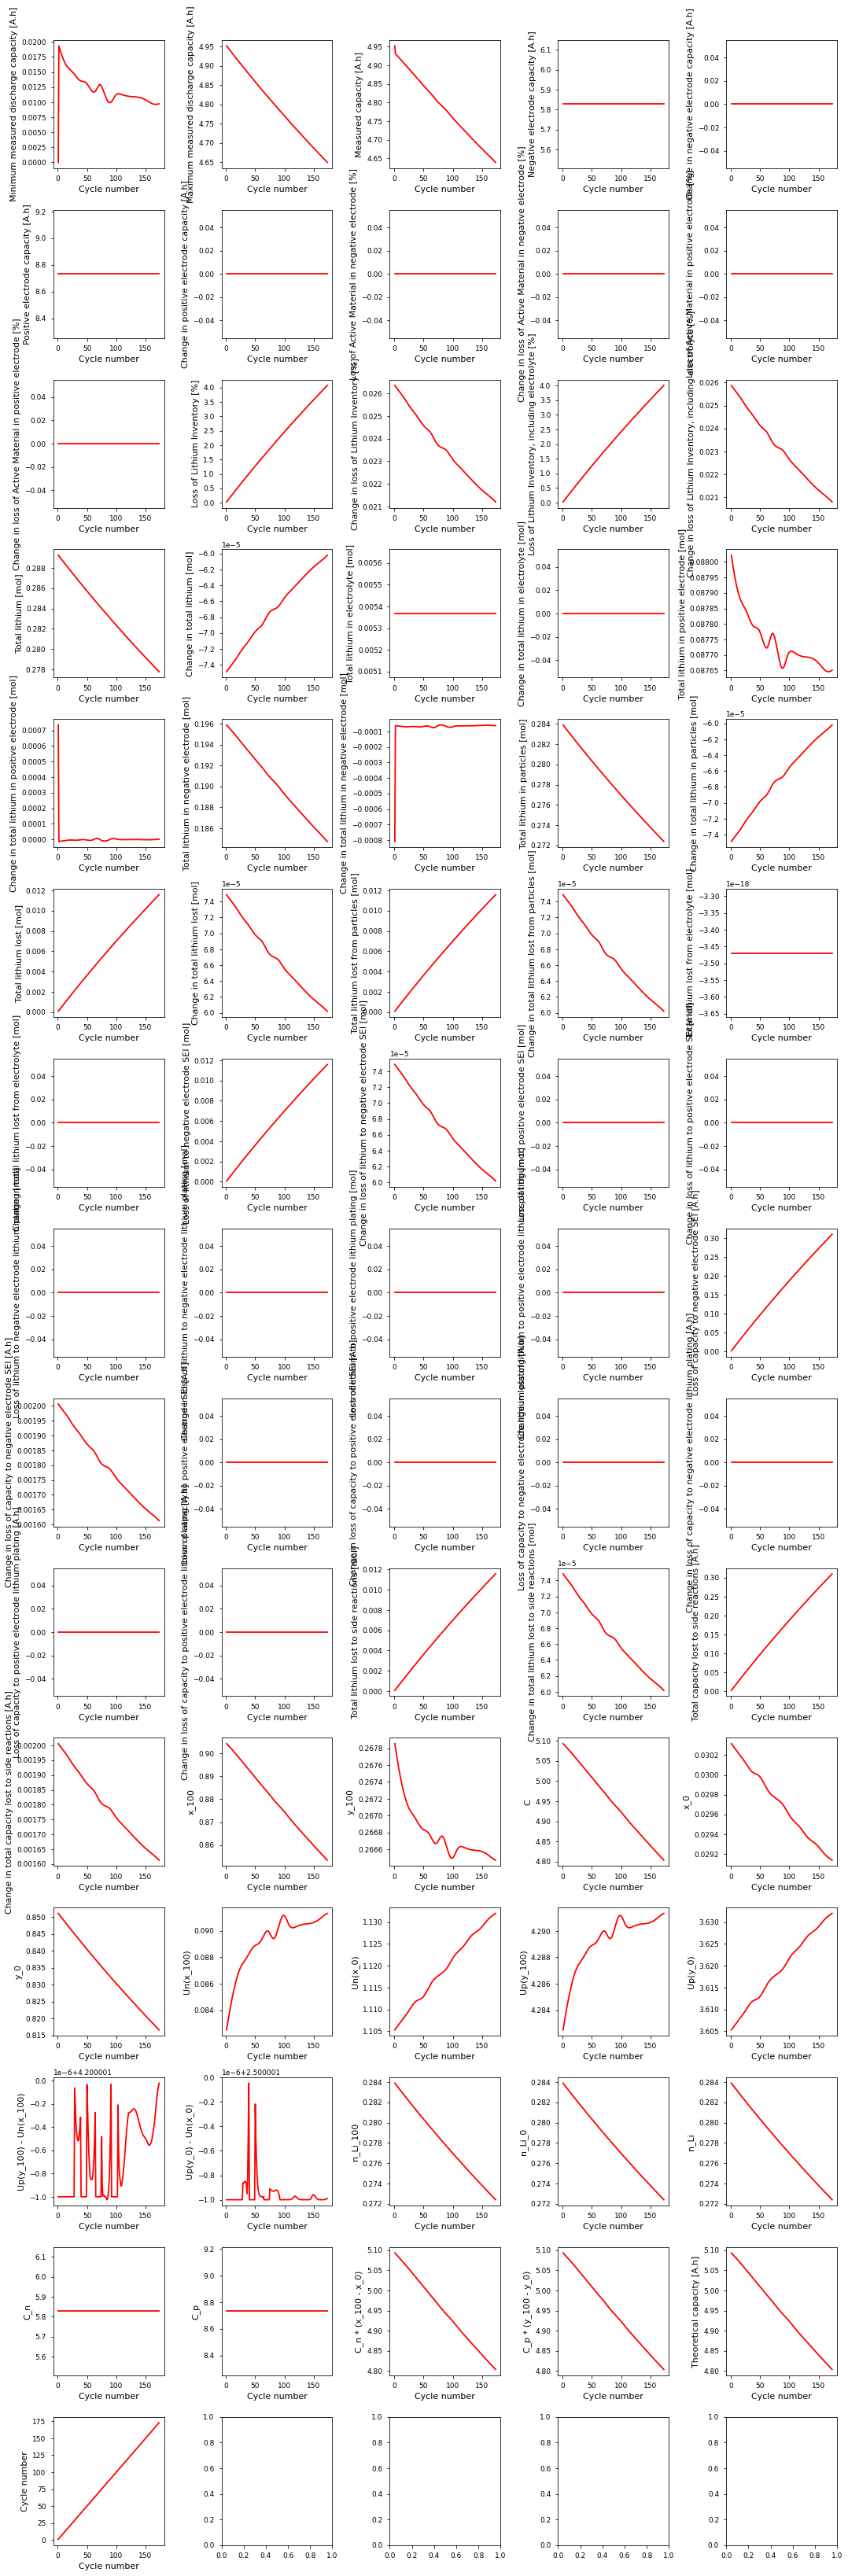

In [20]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [18]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-15 16:32:28,525 - [NOTICE] simulation.solve(693): Cycle 1/1 (32.992 ms elapsed) --------------------
2021-03-15 16:32:28,526 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:28,789 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:28,994 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:29,175 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:29,596 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.104 s


Check how well extrapolating 1 cycle does

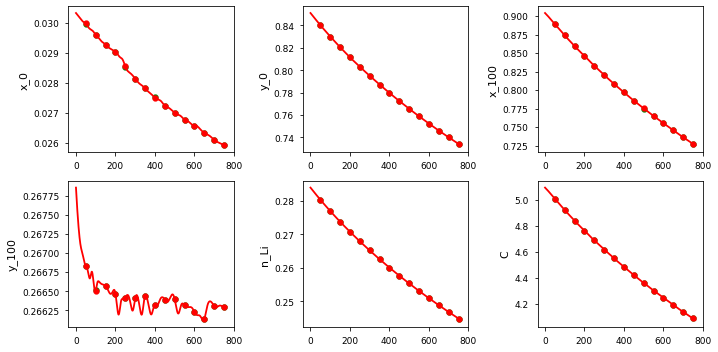

In [19]:
n_cycles_step = 50
long_sol = spm_sol_100
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [20]:
n_cycles_step = 60
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

0


2021-03-15 16:32:37,404 - [NOTICE] simulation.solve(693): Cycle 1/1 (25.402 ms elapsed) --------------------
2021-03-15 16:32:37,405 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:37,628 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:37,824 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:38,018 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:38,445 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.066 s
2021-03-15 16:32:38,500 - [NOTICE] simulation.solve(693): Cycle 1/1 (31.206 ms elapsed) --------------------
2021-03-15 16:32:38,500 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


60


2021-03-15 16:32:38,721 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:38,907 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:39,056 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:39,411 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 942.396 ms
2021-03-15 16:32:39,452 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.759 ms elapsed) --------------------
2021-03-15 16:32:39,453 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


120


2021-03-15 16:32:39,675 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:39,872 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:40,036 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:40,397 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 971.398 ms
2021-03-15 16:32:40,439 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.470 ms elapsed) --------------------
2021-03-15 16:32:40,440 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


180


2021-03-15 16:32:40,669 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:40,844 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:41,001 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:41,340 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 926.795 ms
2021-03-15 16:32:41,388 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.939 ms elapsed) --------------------
2021-03-15 16:32:41,389 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:41,583 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


240


2021-03-15 16:32:41,747 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:41,896 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:42,240 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 882.676 ms
2021-03-15 16:32:42,283 - [NOTICE] simulation.solve(693): Cycle 1/1 (25.384 ms elapsed) --------------------
2021-03-15 16:32:42,283 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


300


2021-03-15 16:32:42,488 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:42,665 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:42,810 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:43,176 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 918.853 ms
2021-03-15 16:32:43,216 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.900 ms elapsed) --------------------
2021-03-15 16:32:43,216 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


360


2021-03-15 16:32:43,419 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:43,587 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:43,730 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:44,083 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 893.853 ms
2021-03-15 16:32:44,125 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.408 ms elapsed) --------------------
2021-03-15 16:32:44,126 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:44,320 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


420


2021-03-15 16:32:44,486 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:44,633 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:44,981 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 885.935 ms
2021-03-15 16:32:45,026 - [NOTICE] simulation.solve(693): Cycle 1/1 (31.825 ms elapsed) --------------------
2021-03-15 16:32:45,026 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


480


2021-03-15 16:32:45,219 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:45,418 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:45,582 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:45,957 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 962.869 ms
2021-03-15 16:32:46,006 - [NOTICE] simulation.solve(693): Cycle 1/1 (33.169 ms elapsed) --------------------
2021-03-15 16:32:46,007 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


540


2021-03-15 16:32:46,200 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:46,397 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:46,544 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:46,887 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 913.925 ms
2021-03-15 16:32:46,929 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.533 ms elapsed) --------------------
2021-03-15 16:32:46,930 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:47,113 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


600


2021-03-15 16:32:47,285 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:47,439 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:47,779 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 877.114 ms
2021-03-15 16:32:47,818 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.530 ms elapsed) --------------------
2021-03-15 16:32:47,819 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:48,010 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


660


2021-03-15 16:32:48,174 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:48,312 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:48,643 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 851.892 ms
2021-03-15 16:32:48,683 - [NOTICE] simulation.solve(693): Cycle 1/1 (22.196 ms elapsed) --------------------
2021-03-15 16:32:48,684 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


720


2021-03-15 16:32:48,884 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:49,071 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:49,216 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:49,541 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 880.148 ms


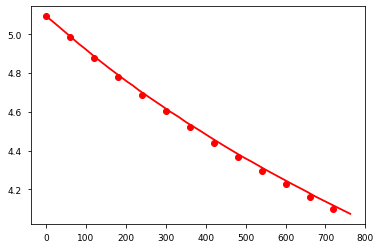

In [21]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

2021-03-15 16:32:49,992 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-15 16:32:49,993 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


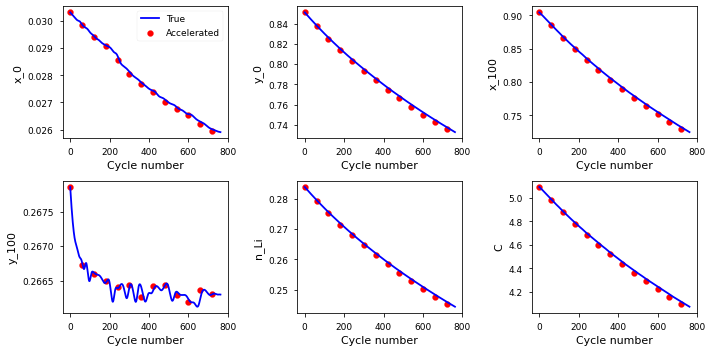

In [22]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)

### Time upscaling

In [23]:
n_cycles_step = 3
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_upscale = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_upscale = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_upscale.solve()
    
    for var in sol.all_models[0].initial_conditions:
        first = sim_upscale.solution.first_state[var.name].data
        last = sim_upscale.solution.last_state[var.name].data
        ics[var.name] = first + (last - first) * n_cycles_step
    sim_upscale.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)
    print(ics['X-averaged positive particle concentration'])
    cycle_nums.append(cycle)
    sol_upscale.append(sol)
    cycle += n_cycles_step

0


2021-03-15 16:32:53,070 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.283 ms elapsed) --------------------
2021-03-15 16:32:53,070 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-15 16:32:53,283 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:53,482 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:53,670 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:54,121 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.078 s
2021-03-15 16:32:54,154 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.158 ms elapsed) --------------------
2021-03-15 16:32:54,155 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.28810488]
 [0.28805397]
 [0.28792696]
 [0.28773028]
 [0.28746648]
 [0.28713763]
 [0.28674592]
 [0.28629375]
 [0.2857838 ]
 [0.28521906]
 [0.28460278]
 [0.28393851]
 [0.28323003]
 [0.28248137]
 [0.28169676]
 [0.28088064]
 [0.28003757]
 [0.27917227]
 [0.27828955]
 [0.27739429]
 [0.27649141]
 [0.27558583]
 [0.27468246]
 [0.27378615]
 [0.27290165]
 [0.27203362]
 [0.27118653]
 [0.27036472]
 [0.26957229]
 [0.2688131 ]]
3


2021-03-15 16:32:54,380 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:54,568 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:54,726 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:55,118 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 993.121 ms
2021-03-15 16:32:55,146 - [NOTICE] simulation.solve(693): Cycle 1/1 (23.704 ms elapsed) --------------------
2021-03-15 16:32:55,146 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.24721928]
 [0.24727084]
 [0.24739948]
 [0.2475987 ]
 [0.24786588]
 [0.24819892]
 [0.24859559]
 [0.24905344]
 [0.24956973]
 [0.25014142]
 [0.25076517]
 [0.25143739]
 [0.25215418]
 [0.25291145]
 [0.25370487]
 [0.25452992]
 [0.25538194]
 [0.2562561 ]
 [0.25714751]
 [0.25805118]
 [0.2589621 ]
 [0.25987525]
 [0.26078563]
 [0.26168831]
 [0.26257844]
 [0.2634513 ]
 [0.26430234]
 [0.26512718]
 [0.26592166]
 [0.26668188]]
6


2021-03-15 16:32:55,352 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:55,527 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:55,682 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:56,060 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 938.096 ms
2021-03-15 16:32:56,088 - [NOTICE] simulation.solve(693): Cycle 1/1 (25.099 ms elapsed) --------------------
2021-03-15 16:32:56,089 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.32855087]
 [0.32839812]
 [0.32801706]
 [0.32742693]
 [0.3266354 ]
 [0.32564873]
 [0.32447344]
 [0.32311676]
 [0.32158675]
 [0.31989234]
 [0.31804333]
 [0.31605034]
 [0.31392474]
 [0.31167861]
 [0.30932468]
 [0.30687621]
 [0.30434693]
 [0.301751  ]
 [0.29910282]
 [0.29641705]
 [0.29370844]
 [0.29099177]
 [0.28828174]
 [0.2855929 ]
 [0.28293951]
 [0.28033551]
 [0.27779437]
 [0.27532902]
 [0.27295178]
 [0.27067427]]
9


2021-03-15 16:32:56,295 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:56,480 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:56,638 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-15 16:32:56,996 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 933.118 ms
2021-03-15 16:32:57,028 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.419 ms elapsed) --------------------
2021-03-15 16:32:57,029 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.16549781]
 [0.16575427]
 [0.16639405]
 [0.16738483]
 [0.16871371]
 [0.17037015]
 [0.17234317]
 [0.1746206 ]
 [0.17718884]
 [0.18003285]
 [0.1831361 ]
 [0.18648071]
 [0.19004749]
 [0.19381605]
 [0.19776498]
 [0.20187188]
 [0.20611358]
 [0.21046625]
 [0.21490554]
 [0.21940677]
 [0.22394504]
 [0.22849545]
 [0.23303318]
 [0.23753375]
 [0.24197309]
 [0.24632775]
 [0.25057505]
 [0.25469323]
 [0.2586616 ]
 [0.26246065]]
12


2021-03-15 16:32:57,253 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-15 16:32:57,429 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-15 16:32:57,588 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


SolverError: CasADI solver failed because the following interpolation bounds were exceeded at the initial conditions: ['nmc_LGM50_ocp_Chen2020 lower bound']. You may need to provide additional interpolation points outside these bounds.

In [ ]:
sol_fast = sol_upscale
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()

It doesn't work because y_100 is much too non-linear, so extrapolating the change gives inaccurate results

### Linear extrapolation

In [25]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
] * 2)
n_cycles_step = 60

sim_acc_linear = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc_linear = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate two cycles
    sol = sim_acc_linear.solve()
    
    n_Li_cycle_init = sol.cycles[-2].first_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_mid = sol.cycles[-2].last_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_last = sol.cycles[-1].last_state["Total lithium in particles [mol]"].data[0]

    delta_nLi_cycle_0 = n_Li_cycle_mid - n_Li_cycle_init
    delta_nLi_cycle_1 = n_Li_cycle_last - n_Li_cycle_mid
    delta_nLi_cycle_N = delta_nLi_cycle_0 + (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step
    
    # Linear extrapolation and integrate (triangle) to get the total n_li over cycles being stepped
#     delta_nLi_total = delta_nLi_cycle_0 + (n_cycles_step-1) * (delta_nLi_cycle_0 + delta_nLi_cycle_N) / 2
    delta_nLi_total = (
        delta_nLi_cycle_0 * n_cycles_step 
        + 1/2 * (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step * (n_cycles_step + 1)
    )
    n_Li = n_Li_cycle_init + delta_nLi_total

    print(n_Li_cycle_init)
    print(n_Li)
    print(n_Li_cycle_init + n_cycles_step * delta_nLi_cycle_0)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc_linear.solution.first_state[var.name].data
            last = sim_acc_linear.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc_linear.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc_linear.append(sol)
    cycle += n_cycles_step

0


2021-03-15 17:55:25,504 - [NOTICE] simulation.solve(693): Cycle 1/2 (23.091 ms elapsed) --------------------
2021-03-15 17:55:25,505 - [NOTICE] simulation.solve(723): Cycle 1/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:25,723 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:25,903 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:26,100 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:26,528 - [NOTICE] simulation.solve(693): Cycle 2/2 (1.048 s elapsed) --------------------
2021-03-15 17:55:26,529 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:26,722 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:26,894 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:27,058 - [NOTICE] simulation.solve(723): Cycle 2/2, step

0.28396609689240004
0.27968615845963096
0.2794745134395431
60


2021-03-15 17:55:27,593 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:27,768 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:27,931 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:28,327 - [NOTICE] simulation.solve(693): Cycle 2/2 (975.975 ms elapsed) --------------------
2021-03-15 17:55:28,327 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:28,522 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:28,698 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:28,864 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:29,148 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.797 s
2021-03-15 17:55:29,184 - [NOTICE] simulation.solve(693): Cycle 1/2 (31.154 ms el

0.27968615845963096
0.27585167058532634
0.2756727145361003
120


2021-03-15 17:55:29,397 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:29,590 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:29,740 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:30,144 - [NOTICE] simulation.solve(693): Cycle 2/2 (991.037 ms elapsed) --------------------
2021-03-15 17:55:30,144 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:30,341 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:30,519 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:30,684 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:31,000 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.847 s
2021-03-15 17:55:31,039 - [NOTICE] simulation.solve(693): Cycle 1/2 (32.474 ms el

0.27585167058532634
0.27237855514427745
0.2722144494059907
180


2021-03-15 17:55:31,271 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:31,442 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:31,600 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:31,979 - [NOTICE] simulation.solve(693): Cycle 2/2 (972.471 ms elapsed) --------------------
2021-03-15 17:55:31,980 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:32,171 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:32,348 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:32,535 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:32,840 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.834 s
2021-03-15 17:55:32,872 - [NOTICE] simulation.solve(693): Cycle 1/2 (26.550 ms el

0.27237855514427745
0.2691553213748914
0.269029182411447
240


2021-03-15 17:55:33,153 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:33,338 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:33,480 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:39,953 - [NOTICE] simulation.solve(693): Cycle 2/2 (7.108 s elapsed) --------------------
2021-03-15 17:55:39,954 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:40,194 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:40,402 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:40,574 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:40,886 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 8.040 s
2021-03-15 17:55:40,922 - [NOTICE] simulation.solve(693): Cycle 1/2 (30.316 ms elaps

0.2691553213748914
0.26611820698824107
0.26602547060825255
300


2021-03-15 17:55:41,147 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:41,350 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:41,546 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:41,953 - [NOTICE] simulation.solve(693): Cycle 2/2 (1.062 s elapsed) --------------------
2021-03-15 17:55:41,954 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:42,179 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:42,379 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:42,537 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:42,902 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 2.010 s
2021-03-15 17:55:42,939 - [NOTICE] simulation.solve(693): Cycle 1/2 (30.144 ms elaps

0.26611820698824107
0.2632905575901916
0.263171320624737
360


2021-03-15 17:55:43,147 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:43,326 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:43,455 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:43,818 - [NOTICE] simulation.solve(693): Cycle 2/2 (909.018 ms elapsed) --------------------
2021-03-15 17:55:43,819 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:43,980 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:44,145 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:44,283 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:44,571 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.662 s
2021-03-15 17:55:44,610 - [NOTICE] simulation.solve(693): Cycle 1/2 (28.778 ms el

0.2632905575901916
0.2606517617792924
0.26051943167017355
420


2021-03-15 17:55:44,975 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:45,165 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:45,548 - [NOTICE] simulation.solve(693): Cycle 2/2 (967.284 ms elapsed) --------------------
2021-03-15 17:55:45,549 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:45,724 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:45,927 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:46,074 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:46,393 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.812 s
2021-03-15 17:55:46,429 - [NOTICE] simulation.solve(693): Cycle 1/2 (28.394 ms elapsed) --------------------
2021-03-15 17:55:46,429 - [NOTICE] simulation.solve(723): Cycle 1/2

0.26065176177929233
0.258081683685553
0.2580078559163233
480


2021-03-15 17:55:46,793 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:46,924 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:47,300 - [NOTICE] simulation.solve(693): Cycle 2/2 (899.215 ms elapsed) --------------------
2021-03-15 17:55:47,300 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:47,459 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:47,643 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:47,792 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:48,074 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.674 s
2021-03-15 17:55:48,107 - [NOTICE] simulation.solve(693): Cycle 1/2 (26.660 ms elapsed) --------------------
2021-03-15 17:55:48,107 - [NOTICE] simulation.solve(723): Cycle 1/2

0.25808168368555306
0.25563768499056827
0.2555636612606509
540


2021-03-15 17:55:48,489 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:48,625 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:49,048 - [NOTICE] simulation.solve(693): Cycle 2/2 (967.425 ms elapsed) --------------------
2021-03-15 17:55:49,049 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:49,228 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:49,399 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:49,556 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:49,830 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.750 s
2021-03-15 17:55:49,857 - [NOTICE] simulation.solve(693): Cycle 1/2 (21.880 ms elapsed) --------------------
2021-03-15 17:55:49,858 - [NOTICE] simulation.solve(723): Cycle 1/2

0.25563768499056827
0.25326924381055815
0.2532378562936176
600


2021-03-15 17:55:50,290 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:50,438 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:50,828 - [NOTICE] simulation.solve(693): Cycle 2/2 (992.405 ms elapsed) --------------------
2021-03-15 17:55:50,829 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:51,002 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:51,176 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:51,310 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:51,587 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.751 s
2021-03-15 17:55:51,624 - [NOTICE] simulation.solve(693): Cycle 1/2 (28.655 ms elapsed) --------------------
2021-03-15 17:55:51,624 - [NOTICE] simulation.solve(723): Cycle 1/2

0.25326924381055815
0.25103464032776457
0.2509663517302878
660


2021-03-15 17:55:51,830 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:52,032 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:52,211 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:52,667 - [NOTICE] simulation.solve(693): Cycle 2/2 (1.072 s elapsed) --------------------
2021-03-15 17:55:52,667 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:52,882 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:53,110 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:53,235 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:53,510 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.915 s
2021-03-15 17:55:53,544 - [NOTICE] simulation.solve(693): Cycle 1/2 (25.606 ms elaps

0.25103464032776457
0.24887950214992727
0.24882029400296202
720


2021-03-15 17:55:53,911 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:54,040 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:54,401 - [NOTICE] simulation.solve(693): Cycle 2/2 (883.353 ms elapsed) --------------------
2021-03-15 17:55:54,402 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-15 17:55:54,562 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-15 17:55:54,743 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-15 17:55:54,877 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-15 17:55:55,170 - [NOTICE] simulation.solve(815): Finish experiment simulation, took 1.652 s


0.24887950214992727
0.24683576464591145
0.24674154054809816


In [ ]:
len(cycle_nums)

In [ ]:
sol_fast = sol_acc_linear
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name][0] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims_linear.eps", dpi=1000)